# House Price Prediction with Linear Regression (NumPy-Only)

Predicting house prices is a classic machine learning problem — simple on the surface, but rich in practical insight. In this project, we’ll build a linear regression model **from scratch** using only **NumPy** and **Pandas** only for data loading and exploration., without relying on high-level ML libraries like scikit-learn or TensorFlow.

We'll use the [Seattle House Price Prediction dataset](https://www.kaggle.com/datasets/samuelcortinhas/house-price-prediction-seattle) from Kaggle, which contains features like square footage, number of bedrooms, and zip code to predict the price of a house.

This project will walk through:
- Loading and preprocessing real-world data
- Implementing the cost function and gradient descent from scratch
- Applying feature scaling for stable training
- Visualizing the model's learning progress
- Making predictions and evaluating performance

> **Why build from scratch?**  
> Anyone can `.fit()` a model, but writing the algorithm manually shows true understanding — something recruiters and hiring managers value highly. It's also the best way to demystify what's happening under the hood of machine learning.

Let's get started!

## Import Libraries

In [1027]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Load the Seattle Housing Dataset

To begin, we load the dataset containing real-world housing data from Seattle, WA. This dataset includes features such as square footage, number of bedrooms, location (zip code), and more — all of which influence the price of a house.

Let's load the data and take a first look at its structure.

In [1028]:
# Load the dataset in a Pandas Dataframe
df = pd.read_csv('train.csv')

# Preview first few rows
df.head()

,beds,baths,size,size_units,lot_size,lot_size_units,zip_code,price
0,3,2.5,2590.0,sqft,6000.00,sqft,98144,795000.0
1,4,2.0,2240.0,sqft,0.31,acre,98106,915000.0
2,4,3.0,2040.0,sqft,3783.00,sqft,98107,950000.0
3,4,3.0,3800.0,sqft,5175.00,sqft,98199,1950000.0
4,2,2.0,1042.0,sqft,NaN,NaN,98102,950000.0


### 1.1 Basic Exploration

Before we begin modeling, it's crucial to understand the structure and quality of the dataset. This step helps us:

- Check how many samples and features we have
- Identify any missing values or anomalies
- Understand the basic distribution of values (e.g., price range, square footage)

Exploratory steps like these ensure that we don't feed incomplete or misleading data into our model.

Let’s begin by checking the shape of the dataset, its columns, and whether there are any missing values.

In [1029]:
# Shape of the dataset
print(f"Dataset Shape: {df.shape[0]} rows, {df.shape[1]} columns")

Dataset Shape: 2016 rows, 8 columns


In [1030]:
# List of column names
df.columns.tolist()

['beds',
 'baths',
 'size',
 'size_units',
 'lot_size',
 'lot_size_units',
 'zip_code',
 'price']

In [1031]:
# Check for missing values
print("Missing values:")
print(df.isnull().sum())

Missing values:
beds                0
baths               0
size                0
size_units          0
lot_size          347
lot_size_units    347
zip_code            0
price               0
dtype: int64


In [1032]:
# Quick statistical summary
df.describe()

,beds,baths,size,lot_size,zip_code,price
count,2016.000000,2016.000000,2016.000000,1669.000000,2016.000000,2.016000e+03
mean,2.857639,2.159970,1735.740575,3871.059694,98123.638889,9.636252e+05
std,1.255092,1.002023,920.132591,2719.402066,22.650819,9.440954e+05
min,1.000000,0.500000,250.000000,0.230000,98101.000000,1.590000e+05
25%,2.000000,1.500000,1068.750000,1252.000000,98108.000000,6.017500e+05
50%,3.000000,2.000000,1560.000000,4000.000000,98117.000000,8.000000e+05
75%,4.000000,2.500000,2222.500000,6000.000000,98126.000000,1.105250e+06
max,15.000000,9.000000,11010.000000,9998.000000,98199.000000,2.500000e+07


### 1.2 Data Cleaning & Preprocessing

Our dataset is fairly simple, but still needs some cleaning to ensure the features are usable in a linear regression model.

Key issues identified:
- The `lot_size` column uses **mixed units** (`sqft` and `acre`), which need to be standardized
- The `size` column uses a separate `size_units` column — we should ensure all sizes are in **square feet**
- Some rows contain **missing values**
- We'll keep only the features that make sense for price prediction, and drop unit-related columns after standardization

Let’s clean the data accordingly.


#### 1.2.1 Create a copy of Dataframe
To avoid messing with the original data, its advisable to create a copy of the data before you start making adjustments to it. Then we can go on and check for consistencies in our columns of interests especially the `units` columns.

In [1033]:
# Copy original data to avoid modifying the raw DataFrame
df_clean = df.copy()

# Check the consistency of the size units
print(f"Size units available: {df_clean['size_units'].unique()}")

Size units available: ['sqft']


In [1034]:
# Check the consistency of the lot-size units
print(f"Lot-size units available: {df_clean['lot_size_units'].unique()}")

Lot-size units available: ['sqft' 'acre' nan]


#### 1.2.2 Fix the inconsistent columns
Since we only have 1 inconsistent column `lot_size_units` we will convert the `acres` into `square feet` for better training of our model.

In [1035]:
# Convert all lot sizes to square feet
def convert_lot_size(row):
    if row['lot_size_units'] == 'acre':
        return row['lot_size'] * 43560  # 1 acre = 43,560 sqft
    return row['lot_size']  # already in sqft


df_clean['lot_size_sqft'] = df_clean.apply(convert_lot_size, axis=1)
df_clean.head()

,beds,baths,size,size_units,lot_size,lot_size_units,zip_code,price,lot_size_sqft
0,3,2.5,2590.0,sqft,6000.00,sqft,98144,795000.0,6000.0
1,4,2.0,2240.0,sqft,0.31,acre,98106,915000.0,13503.6
2,4,3.0,2040.0,sqft,3783.00,sqft,98107,950000.0,3783.0
3,4,3.0,3800.0,sqft,5175.00,sqft,98199,1950000.0,5175.0
4,2,2.0,1042.0,sqft,NaN,NaN,98102,950000.0,NaN


#### 1.2.3 Drop rows with missing values
Since the missing values will really affect our training data we will drop the rows with missing values

In [1036]:
# Drop rows with missing values
df_clean.dropna(inplace=True)

# Check missing values after drop
print("Missing values (after drop):")
print(df_clean.isnull().sum())

Missing values (after drop):
beds              0
baths             0
size              0
size_units        0
lot_size          0
lot_size_units    0
zip_code          0
price             0
lot_size_sqft     0
dtype: int64


#### 1.2.4 Drop the unnecessary columns
Since we are not going to use the qualitative date to train the model, we can drop those columns from the training data and also columns such as `size` and `lot_size` will be represented by the new `lot_size_sqft`.

In [1037]:
# Drop columns we no longer need (units)
df_clean.drop(columns=['size_units', 'lot_size', 'lot_size_units'], inplace=True)

# Preview the cleaned data
df_clean.head()

,beds,baths,size,zip_code,price,lot_size_sqft
0,3,2.5,2590.0,98144,795000.0,6000.0
1,4,2.0,2240.0,98106,915000.0,13503.6
2,4,3.0,2040.0,98107,950000.0,3783.0
3,4,3.0,3800.0,98199,1950000.0,5175.0
5,2,2.0,1190.0,98107,740000.0,43560.0


In [1038]:
# Preview the shape of the data
print(f"Rows: {df_clean.shape[0]}, Columns: {df_clean.shape[1]}")

Rows: 1669, Columns: 6


### 1.3 Data Visualization

With the dataset cleaned and standardized, we can now explore how the features relate to house prices.

This step helps us:
- Understand which features are most predictive
- Spot patterns and trends (e.g., linear or nonlinear relationships)
- Identify potential outliers

Since we'll be building a **simple linear regression model from scratch**, we'll focus on **numerical features** that have a strong, linear correlation with the target variable `price`.

Let’s start by plotting relationships between each key feature and `price`.


#### 1.3.1 Visualizing numerical features
Let's visualize the numerical features like: `size_sqft`, `lot_size_sqft`, `beds`, `baths` versus the `price`.

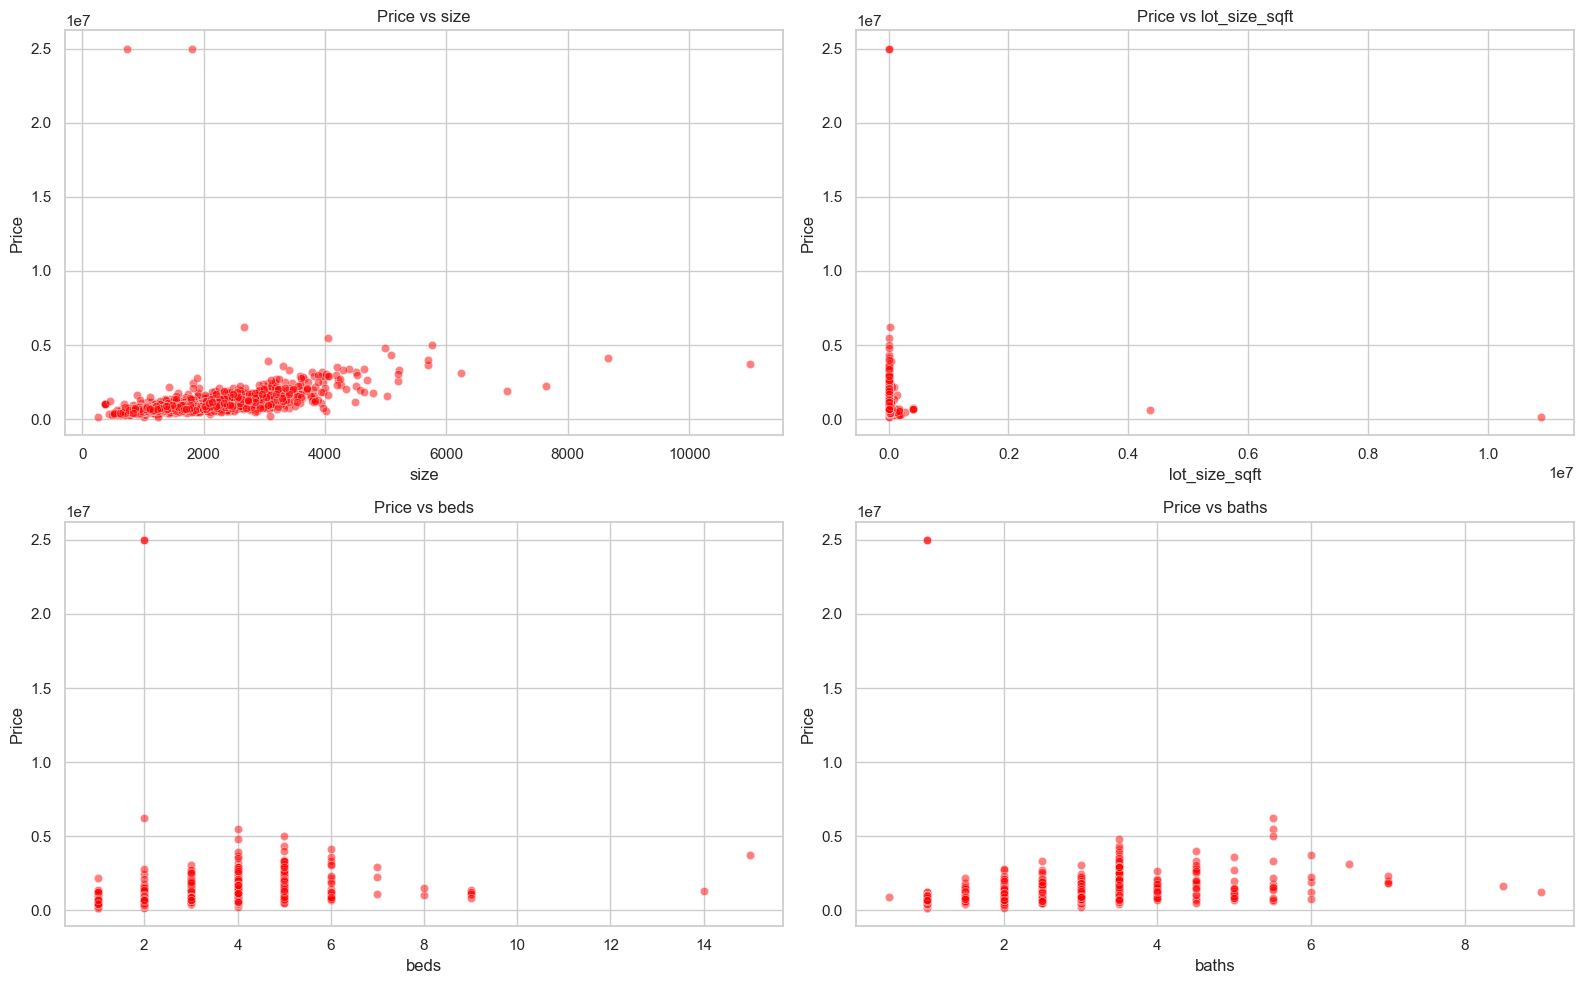

In [1039]:
# Set a clean style
sns.set(style='whitegrid')

# List of numerical features
features = ['size', 'lot_size_sqft', 'beds', 'baths']

# Plot each feature against price
plt.figure(figsize=(16, 10))
for idx, col in enumerate(features, 1):
    plt.subplot(2, 2, idx)
    sns.scatterplot(data=df_clean, x=col, y='price', alpha=0.5, color='red')
    plt.title(f'Price vs {col}')
    plt.xlabel(col)
    plt.ylabel('Price')

plt.tight_layout()
plt.show()

#### 1.3.2 Visualizing with a correlation heatmap
This helps in reinforcing our visual observation

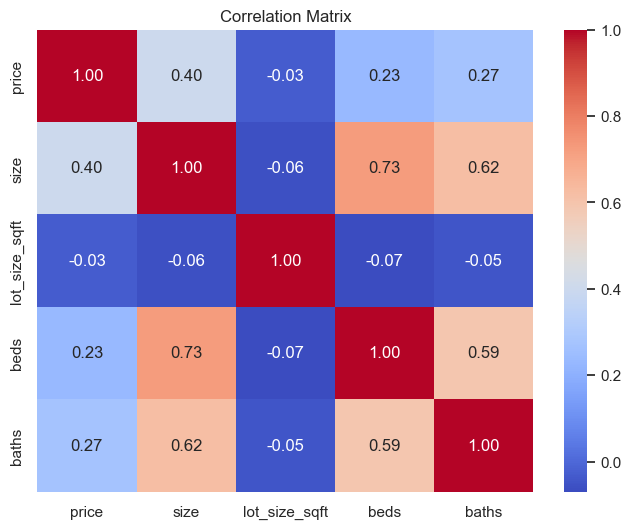

In [1040]:
# Only numerical columns
num_cols = ['price', 'size', 'lot_size_sqft', 'beds', 'baths']
corr = df_clean[num_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

## 2.0 Feature Selection & Modeling Plan

Before building our model, we need to choose the best feature(s) to use as input (`X`) for predicting house price (`y`).

From our earlier visualizations and the correlation matrix, we can evaluate which feature has the strongest linear relationship with `price`.

### Observations:
- **`size_sqft`** shows a strong, direct, linear trend with price — as the size of the house increases, so does the price.
- **`lot_size_sqft`** appears noisier, with weaker correlation.
- **`beds` and `baths`** show step-wise relationships (categorical-like), not smooth trends — these are useful in more complex models, but not ideal for a basic linear regression from scratch.

### Selected Feature: `size_sqft`

We’ll use `size_sqft` as our **single input feature (`X`)** for predicting `price` (`y`) in our linear regression model.

<br>

### Modeling Plan:

We'll implement linear regression manually using **NumPy only**, including:

1. **Feature Scaling** using Z-score normalization
2. Implementing the **Cost Function (MSE)**
3. Implementing **Gradient Descent**
4. Training the model by minimizing cost
5. Making predictions and visualizing results
6. Evaluating model performance (RMSE, R²)

> No high-level libraries like `scikit-learn` will be used for modeling — we’re doing everything from scratch to truly understand how linear regression works under the hood.


In [1041]:
# Quick check of correlations to price
df_clean[['size', 'lot_size_sqft', 'beds', 'baths', 'price']].corr()['price'].sort_values(ascending=False)

price            1.000000
size             0.402324
baths            0.271502
beds             0.233960
lot_size_sqft   -0.029089
Name: price, dtype: float64

### 2.1 Feature Scaling (Standardization)

Before training our linear regression model, it's important to scale our input features. This is especially critical when using **gradient descent**, as it ensures faster and more stable convergence.

We'll use **Z-score standardization**, which transforms our feature `X` into a distribution with:
- Mean = 0
- Standard deviation = 1

The formula is:

$$
X_{\text{scaled}} = \frac{X - \mu}{\sigma}
$$


Where:
- $\mu$ is the mean of the feature
- $\sigma$ is the standard deviation of the feature

This ensures the feature values are on the same scale, making gradient descent more effective.

In [1042]:
# Extract the feature and target
X = df_clean['size']
y = df_clean['price']

# Extract the feature and target
x_mean = X.mean()
x_std = X.std()
X_scaled = (X - x_mean) / x_std

y_mean = y.mean()
y_std = y.std()
y_scaled = (y - y_mean) / y_std

# Print results
print(f"Mean of X: {x_mean:.2f}")
print(f"Standard Deviation of X: {x_std:.2f}")
print(f"First 5 scaled values: {X_scaled[:5]}")

print(f"\nMean of y: {y_mean:.2f}")
print(f"Standard Deviation of y: {y_std:.2f}")
print(f"First 5 scaled values: {y_scaled[:5]}")

Mean of X: 1893.10
Standard Deviation of X: 916.95
First 5 scaled values: 0    0.760020
1    0.378321
2    0.160207
3    2.079608
5   -0.766776
Name: size, dtype: float64

Mean of y: 1038475.21
Standard Deviation of y: 1007943.84
First 5 scaled values: 0   -0.241556
1   -0.122502
2   -0.087778
3    0.904341
5   -0.296123
Name: price, dtype: float64


### 2.2 Cost Function – Mean Squared Error (MSE)

To train our linear regression model, we need a way to measure **how well our model's predictions match the actual values**. This is the role of the **cost function**.

The most commonly used cost function for regression is the **Mean Squared Error (MSE)**:

$$
J(w, b) = \frac{1}{2m} \sum_{i=1}^{m} (\hat{y}^{(i)} - y^{(i)})^2
$$

Where:
- $ m $ is the number of training examples
- $ \hat{y}^{(i)} = w \cdot x^{(i)} + b $ is the predicted value for the i-th example
- $ y^{(i)} $ is the actual target value
- $ w $ is the weight (slope), and $ b $ is the bias (intercept)

>  We include the factor $ \frac{1}{2} $ to simplify the derivative during gradient descent.

This function calculates the **average squared difference** between predicted and actual values — lower is better.


In [1043]:
# Define the cost function
def compute_cost(x_train, y_train, w, b):
    """
    Compute the Mean Squared Error cost function.
    
    Parameters:
    x_train (array): Input features (scaled)
    y_train (array): Actual target values
    w (float): Weight (slope)
    b (float): Bias (intercept)

    Returns:
    float: Cost J(w, b)
    """

    m = len(y)
    y_hat = np.dot(x_train, w) + b
    cost = (1 / (2 * m)) * np.sum((y_hat - y_train) ** 2)
    return cost

### 2.3 Gradient Descent

Now that we can measure the model's error using the cost function (MSE), we need a way to **minimize** that error. This is where **Gradient Descent** comes in.

Gradient Descent is an optimization algorithm that iteratively adjusts the model parameters (weight `w` and bias `b`) to **move in the direction that reduces the cost**.

<br>

#### Update Rules:

$$
w := w - \alpha \cdot \frac{\partial J}{\partial w}
$$
$$
b := b - \alpha \cdot \frac{\partial J}{\partial b}
$$

Where:
- $ \alpha $ is the learning rate, (how big each step is)
- $ \frac{\partial J}{\partial w} $, $ \frac{\partial J}{\partial b} $ are the **gradients** of the cost function with respect to `w` and `b`

#### Intuition:
- The gradients tell us **how steep the slope is** (how fast cost is increasing)
- We move in the **opposite direction of the slope** to minimize cost


In [1044]:
# Define the gradient descent function
def gradient_descent(x_train, y_train, w, b, learning_rate, iterations):
    """
    Performs batch gradient descent to learn w and b.

    Parameters:
    x_train (array): Input features (scaled)
    y_train (array): Target values
    w (float): Initial weight
    b (float): Initial bias
    learning_rate (float): Step size for each update
    iterations (int): Number of training iterations

    Returns:
    w, b (float): Learned parameters
    cost_history (list): Cost at each iteration
    """
    m = len(y)
    cost_history = []

    for i in range(iterations):
        y_hat = np.dot(x_train, w) + b
        error = y_hat - y_train

        # Compute gradients
        dw = (1 / m) * np.dot(error, x_train)
        db = (1 / m) * np.sum(error)

        # Update parameters
        w -= learning_rate * dw
        b -= learning_rate * db

        # Track cost
        cost = compute_cost(x_train, y_train, w, b)

        print(f"Iteration {i}: Cost = {cost:.2f}, w = {w:.4f}, b = {b:.4f}")
        
        if i != 0 and abs(cost - cost_history[-1]) < 1e-06:
            print(f"Converged at iteration {i}")
            break
            
        cost_history.append(cost)
    return w, b, cost_history

### 2.4 Train the Model Using Gradient Descent
We now need to train the model using the gradient descent but first we need to set the hyperparameters

In [1045]:
# Set hyperparameters
iterations = 10000
learning_rate = 0.001
initial_weight = 0
initial_bias = 0

# Train the model
final_weight, final_bias, cost_history = gradient_descent(X_scaled, y_scaled, initial_weight, initial_bias, learning_rate, iterations)
print(f"Final Parameters: w = {final_weight:.4f}, b = {final_bias:.4f}")

Iteration 0: Cost = 0.50, w = 0.0004, b = 0.0000
Iteration 1: Cost = 0.50, w = 0.0008, b = 0.0000
Iteration 2: Cost = 0.50, w = 0.0012, b = 0.0000
Iteration 3: Cost = 0.50, w = 0.0016, b = 0.0000
Iteration 4: Cost = 0.50, w = 0.0020, b = 0.0000
Iteration 5: Cost = 0.50, w = 0.0024, b = 0.0000
Iteration 6: Cost = 0.50, w = 0.0028, b = 0.0000
Iteration 7: Cost = 0.50, w = 0.0032, b = 0.0000
Iteration 8: Cost = 0.50, w = 0.0036, b = 0.0000
Iteration 9: Cost = 0.50, w = 0.0040, b = 0.0000
Iteration 10: Cost = 0.50, w = 0.0044, b = 0.0000
Iteration 11: Cost = 0.50, w = 0.0048, b = 0.0000
Iteration 12: Cost = 0.50, w = 0.0052, b = 0.0000
Iteration 13: Cost = 0.50, w = 0.0056, b = 0.0000
Iteration 14: Cost = 0.50, w = 0.0060, b = 0.0000
Iteration 15: Cost = 0.50, w = 0.0064, b = 0.0000
Iteration 16: Cost = 0.50, w = 0.0068, b = 0.0000
Iteration 17: Cost = 0.50, w = 0.0072, b = 0.0000
Iteration 18: Cost = 0.50, w = 0.0076, b = 0.0000
Iteration 19: Cost = 0.50, w = 0.0080, b = 0.0000
Iteration 

### 2.5 Predictions and Regression Line

With the model trained, we can now generate predictions for house prices using the learned parameters.

Since our model was trained on **standardized data**, we will:
1. Use the learned `w` and `b` to make predictions on `X_scaled`
2. Convert the predictions back to the **original price scale** using the inverse Z-score formula:
   $$
   \hat{y}_{\text{original}} = \hat{y}_{\text{scaled}} \times \sigma_y + \mu_y
   $$
3. Plot the regression line over the original data to visualize how well the model fits.

This will give us a clear view of how accurately our NumPy-based linear regression model captures the relationship between house size and price.


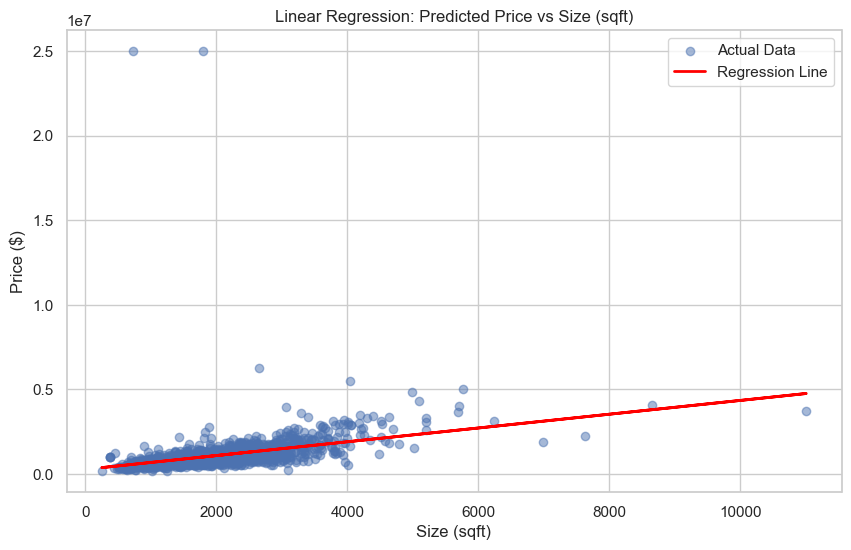

In [1046]:
# Step 1: Predict scaled prices
y_hat_scaled = final_weight * X_scaled + final_bias

# Step 2: Rescale predictions to original price range
y_hat = y_hat_scaled * y_std + y_mean

# Step 3: Plot actual data vs predicted line
plt.figure(figsize=(10, 6))
plt.scatter(X, y, label='Actual Data', alpha=0.5)
plt.plot(X, y_hat, color='red', label='Regression Line', linewidth=2)
plt.title('Linear Regression: Predicted Price vs Size (sqft)')
plt.xlabel('Size (sqft)')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.show()

### 2.6 Model Evaluation: RMSE and R² Score

After training and visualizing the model's fit, we now want to **quantify its performance**.

We'll use two standard regression metrics

<br>

#### 1. **RMSE (Root Mean Squared Error)**  
Measures the average prediction error in the same units as the target variable (price in dollars):

$$
\text{RMSE} = \sqrt{ \frac{1}{m} \sum_{i=1}^{m} (\hat{y}_i - y_i)^2 }
$$

Lower RMSE = better fit.

<br>

#### 2. **R² Score (Coefficient of Determination)**  
Represents the proportion of variance in the target explained by the model:

$$
R^2 = 1 - \frac{ \sum (\hat{y} - y)^2 }{ \sum (y - \bar{y})^2 }
$$

- $ R^2 = 1.0 $: perfect prediction  
- $ R^2 = 0.0 $: model predicts the mean  
- $ R^2 < 0 $: worse than guessing the mean

Let’s compute both to evaluate how well our NumPy-based linear regression model performs.


In [1047]:
# Importing Scikit-Learn library that we will use for our evaluation
from sklearn.metrics import mean_squared_error, r2_score

# Compute RMSE
rmse = np.sqrt(mean_squared_error(y, y_hat))

# Compute R² score
r2 = r2_score(y, y_hat)

# Display results
print(f"RMSE: ${rmse:,.2f}")
print(f"R² Score: {r2:.4f}")

RMSE: $923,043.35
R² Score: 0.1609


## Final Summary & Reflections

In this project, we built a **linear regression model from scratch using NumPy** to predict house prices in Seattle. We worked step by step through the full machine learning pipeline, including:

- **Data cleaning & preprocessing** (unit standardization, missing value handling)
- **Exploratory data analysis** (scatter plots, correlation checks)
- **Feature scaling** using Z-score normalization
- **Model implementation**: cost function (MSE), gradient descent
- **Model training and prediction** with visualization
- **Model evaluation** using RMSE and R² Score

<br>

### Key Learnings

- Implementing algorithms from scratch is the best way to deeply understand how they work
- Feature selection significantly impacts model performance
- Standardizing data is crucial when using gradient descent
- Real-world data is messy — handling units, missing values, and scale differences is essential
- Evaluation metrics tell the **real story** about a model’s performance